### 实验一  迫近梯度下降与次梯度下降求解Lasso问题

>   人工智能1班     2115102001 安炳旭  

#### 准备工作

引入必要的package,做好准备

In [243]:
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用中文黑体
plt.rcParams['axes.unicode_minus'] = False  # 用于正常显示负号
# 使Matplotlib输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 18})

Lasso回归如下式
$$f(\beta)=\frac{1}{2} ||y-X\beta||_2^2+\lambda||\beta||_1$$

其中$X$是特征矩阵,本实验中选取的是一个随机生成的$512\times 1024$的矩阵,$y$是观测值,通过真实的$\beta$生成,本实验旨在寻找一个合适的$\hat{\beta}$,使得$\left\| \beta-\hat{\beta} \right\|^2_2$尽可能小

#### 随机生成数据

下面这段代码用来生成数据,值得注意的是,代码对生成的$y$添加噪声$\epsilon \sim N(0,0.1^2)$,增强模型的鲁棒性

In [244]:
def Generate_Data(X_dim, beta_dim, beta_sparsity, e_dim):
    # 生成具有稀疏特性的真实 beta 向量
    beta_nonzero_index = random.sample(range(beta_dim), beta_sparsity)  # 从范围内随机选择非零元素的下标
    beta_nonzero_element = np.random.normal(0, 1, beta_sparsity)  # 生成非零元素的随机值
    beta_real = np.zeros(beta_dim)
    for i in range(len(beta_nonzero_index)):
        beta_real[beta_nonzero_index] = beta_nonzero_element

    # 生成测量矩阵 X 和噪声向量 e
    X = np.random.normal(0, 1, X_dim)  # 生成服从正态分布的测量矩阵 X
    e = np.random.normal(0, 0.1, e_dim)  # 生成服从正态分布的噪声向量 e

    # 生成观测向量 y，其中 y = X * beta_real + e
    y = X @ beta_real + e

    return beta_real, y, X

定义Lasso问题的函数

In [245]:
def Lasso(y,X,beta,lamda):
    return  0.5*np.linalg.norm(y-X@beta)**2+lamda*np.linalg.norm(beta,1)

---

#### 邻近点梯度下降法

Proximal Gradient Method，又称近端梯度法。

In [246]:
def PGD(beta_dim,X,y,epoch=5000,t=0.0003,lamda=1,epsilon=1e-5):
    beta_k = np.zeros(beta_dim)
    beta_k_old = np.zeros(beta_dim)

    plot_iteration = []  # 每步计算结果
    f_values = []  # 保存每一步的 f 值
    k = 1  # 迭代次数

    while k < epoch:
        beta_k_temp = beta_k - t * X.T @ (X@beta_k - y)  # 对光滑部分做梯度下降
        
        # 临近点投影（软阈值）
        for i in range(beta_dim):
            if beta_k_temp[i] < -t * lamda:
                beta_k[i] = beta_k_temp[i] + t * lamda
            elif beta_k_temp[i] > t * lamda:
                beta_k[i] = beta_k_temp[i] - t * lamda
            else:
                beta_k[i] = 0
                
        plot_iteration.append(beta_k.copy())  # 记录每步计算结果
        f_k = Lasso(y,X,beta_k,lamda)
        f_values.append(f_k)  # 记录每一步的 f 值       
        if np.linalg.norm(beta_k - beta_k_old) < epsilon:
            break
        else:
            beta_k_old = beta_k.copy()  # 深拷贝
            k += 1
            
    beta_optm = beta_k[:]  # 最优解
    print(f"||beta(k)-beta(k-1)||={f_k:.2f}")
    return beta_optm,plot_iteration,f_values

下面这个代码用于画出迭代次数-误差图

In [247]:
def Draw(plot_iteration,optm,real,title,desp):
    plt.figure(figsize=(12, 10))  # 设置图形大小为宽度 10，高度 6

    plot_dist_real = []  # 每步结果与真值的距离
    plot_dist_optm = []  # 每步结果与最优解的距离
    for iter in plot_iteration:
        plot_dist_real.append(np.linalg.norm(iter - real))
        plot_dist_optm.append(np.linalg.norm(iter - optm))
    err=np.linalg.norm(real-optm)
    print(f"||beta-beta*||_2={err:.2f}")

    # 作图
    plt.title(title)
    plt.xlabel('迭代次数')
    plt.ylabel('2范数误差')
    plt.text(0.5, -0.1, desp, ha='center', va='center', transform=plt.gca().transAxes)

    plt.plot(plot_dist_real, 'r', label='beta*与第(k)次迭代的误差')
    plt.plot(plot_dist_optm, 'b', label='最后一次迭代与第(k)次迭代的误差')

    plt.grid()
    plt.legend()

    plt.show()
    return  plot_dist_real,plot_dist_optm,err

---

#### 次梯度法

Subgradient Method,这里的步长选取的是递减步长,也就是$t^{k+1}=\frac{t^{(k)}}{\sqrt k}$,其中$t^{(0)}=0.0003$,参数支持自行修改,

In [248]:
def SGD(beta_dim,X,y,epoch=5000,t_0=0.0003,lamda=1,epsilon=1e-5):
    beta_k = np.zeros(beta_dim)
    beta_k_old = np.zeros(beta_dim)
    f_0=Lasso(y,X,beta_k,lamda)


    plot_iteration = []  # 每步计算结果
    f_values = []  # 保存每一步的 f 值

    k = 1  # 迭代次数

    while k < epoch:
        t = t_0 / np.sqrt(k)  # 递减步长
        # 计算目标函数次梯度
        l1_subgradient = np.zeros(beta_dim)  # L1范数的次梯度
        for i in range(len(beta_k)):
            if beta_k[i] != 0:
                l1_subgradient[i] = np.sign(l1_subgradient[i])
            else:
                l1_subgradient[i] = np.random.uniform(-1, 1)  # 随机取[-1, 1]内的值作为次梯度
        subgradient = X.T @ (X@beta_k - y) + lamda * l1_subgradient
        
        beta_k = beta_k - t * subgradient
        
        plot_iteration.append(beta_k.copy())  # 记录每步计算结果
        f_k = Lasso(y,X,beta_k,lamda)
        f_values.append(f_k)  # 记录每一步的 f 值       
        if np.linalg.norm(beta_k - beta_k_old) < epsilon:
            break
        else:
            beta_k_old = beta_k.copy()  # 深拷贝
            k += 1
            
    beta_optm = beta_k.copy()  # 最优解
    print(f"||beta(k)-beta(k-1)||={f_k:.2f}")
    return beta_optm,plot_iteration,f_values

下面这个代码用于作出SGD与PGD性能对比的图

In [249]:
def  SGD_PGD_cmp(plot_dist_real1,plot_dist_real2):
    # 作图
    plt.figure(figsize=(8, 6))

    # 近邻梯度法
    plt.title('迫近梯度法(PGD)与次梯度法(SGD) 两种迭代方法的对比')
    plt.xlabel('迭代次数')
    plt.ylabel('2范数误差')
    plt.plot(plot_dist_real1, 'r', label='迫近梯度法(PGD) beta*与第(k)次迭代的误差')
    plt.plot(plot_dist_real2, 'b', label='次梯度法(SGD) beta*与第(k)次迭代的误差')
    plt.grid()
    plt.legend()


    plt.tight_layout()
    plt.show()


此部分用于修改数据的信息,如维度,稀疏度等

In [250]:
X_dim = (512, 1024)
beta_dim = 1024
beta_sparsity = 102  # 稀疏度
e_dim = 512

生成数据,并使用迫近梯度下降

||beta(k)-beta(k-1)||=81.51
||beta-beta*||_2=0.14


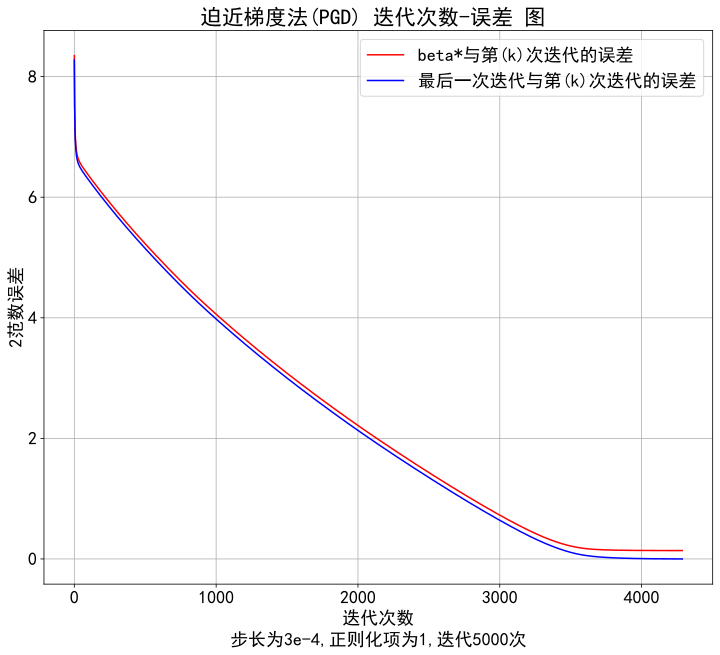

In [252]:
beta_real,y,X=Generate_Data(X_dim,beta_dim,beta_sparsity,e_dim)

beta_optm,plot_iteration,f_values1=PGD(beta_dim,X,y,5000,3e-4,1,1e-5)
np.count_nonzero(beta_optm)  # 稀疏度
title='迫近梯度法(PGD) 迭代次数-误差 图 '
desp='步长为3e-4,正则化项为1,迭代5000次'
plot_dist_real1,plot_dist_optm1,err=Draw(plot_iteration,beta_optm,beta_real,title,desp)


调整参数,再实现一个迫近梯度下降

||beta(k)-beta(k-1)||=869.66
||beta-beta*||_2=2.64


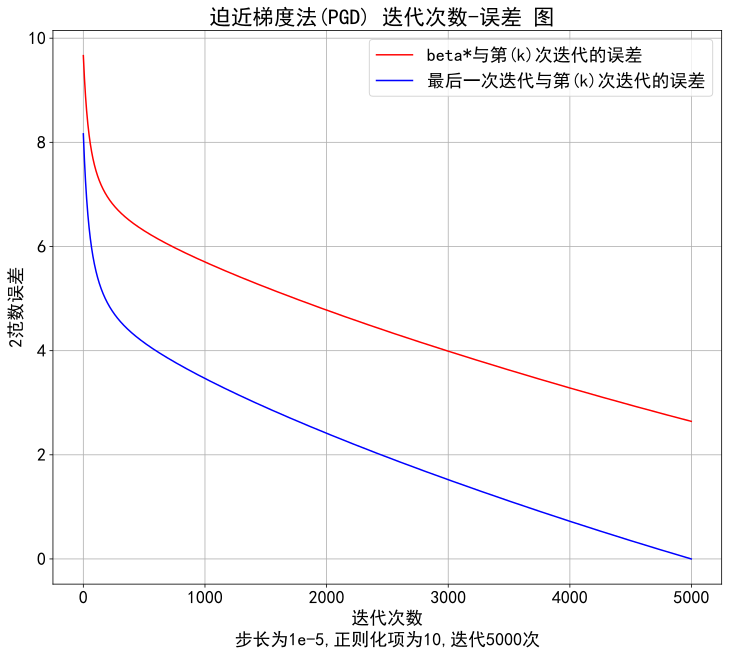

稀疏度为:0.5302734375


In [253]:
beta_real,y,X=Generate_Data(X_dim,beta_dim,beta_sparsity,e_dim)

beta_optm,plot_iteration,f_values=PGD(beta_dim,X,y,5000,1e-5,10,1e-5)
title='迫近梯度法(PGD) 迭代次数-误差 图 '
desp='步长为1e-5,正则化项为10,迭代5000次'
plot_dist_real,plot_dist_optm,err=Draw(plot_iteration,beta_optm,beta_real,title,desp)


使用次梯度法

||beta-beta*||_2=6.66


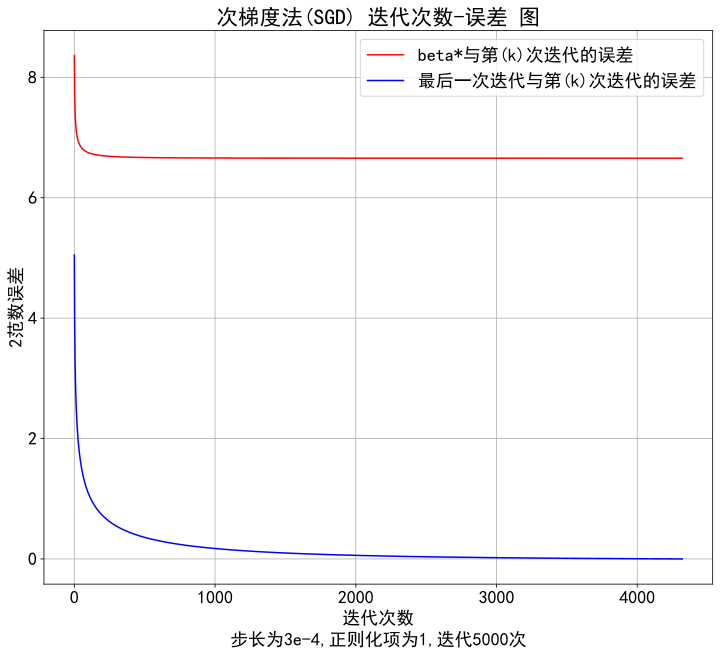

In [255]:
beta_optm,plot_iteration,f_values2=SGD(beta_dim,X,y,5000,3e-4,1,1e-5)
title='次梯度法(SGD) 迭代次数-误差 图'
desp='步长为3e-4,正则化项为1,迭代5000次'

plot_dist_real2,plot_dist_optm2,err=Draw(plot_iteration,beta_optm,beta_real,title,desp)

调整参数，再次使用次梯度法，与上面的进行比较

||beta(k)-beta(k-1)||=2831.61
||beta-beta*||_2=7.32


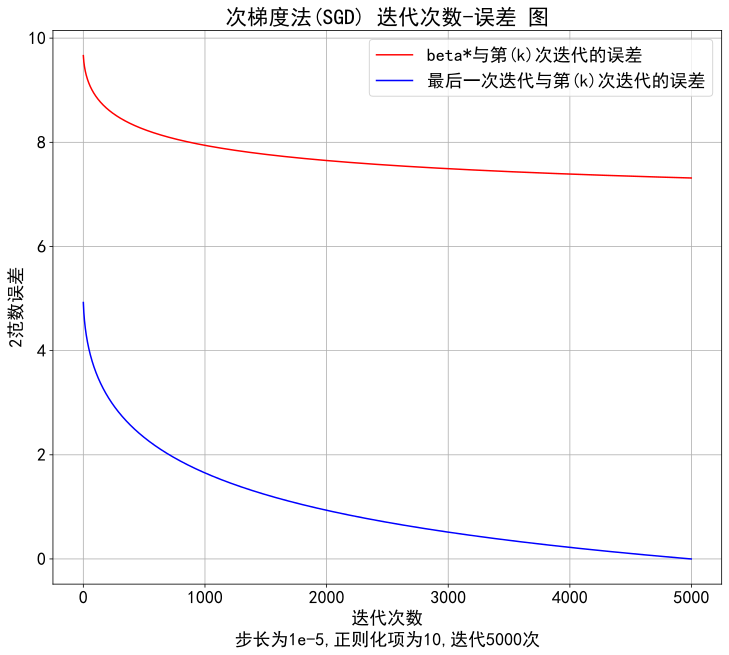

In [256]:
beta_optm,plot_iteration,f_values=SGD(beta_dim,X,y,5000,1e-5,10,1e-5)
np.count_nonzero(beta_optm)
title='次梯度法(SGD) 迭代次数-误差 图'
desp='步长为1e-5,正则化项为10,迭代5000次'

plot_dist_real,plot_dist_optm,err=Draw(plot_iteration,beta_optm,beta_real,title,desp)

最后生成二者的对比

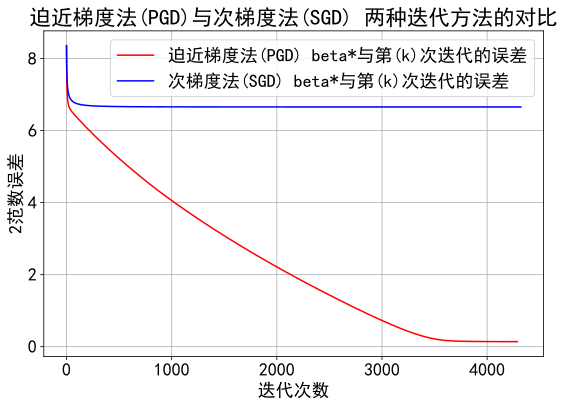

In [257]:
SGD_PGD_cmp(plot_dist_real1,plot_dist_real2)